# Assignment 4: Final Project
Authors: Naomi Buell and Richie Rivera

## *Instructions:*

1. Choose a dataset: You get to decide which dataset you want to work on. The data set must be different from the ones used in previous homeworks You can work on a problem from your job, or something you are interested in. You may also obtain a dataset from sites such as Kaggle, Data.Gov, Census Bureau, USGS or other open data portals. 

2. Select one of the methodologies studied in weeks 1-10, and another methodology from weeks 11-15 to apply in the new dataset selected.

3. To complete this task:
    - Describe the problem you are trying to solve.
    - Describe your datasest and what you did to prepare the data for analysis. 
    - Methodologies you used for analyzing the data
    - What's the purpose of the analysis performed
    - Make your conclusions from your analysis. Please be sure to address the business impact (it could be of any domain) of your solution.

## Introduction

### The Problem

This project seeks to answer the research question: **What factors influence user reviews for Steam video games?** Steam is a popular digital distribution platform for video games, and user reviews play a significant role in shaping the perception and success of games on the platform. In this analysis, we will try to predict whether or not a game will receive a thumbs up or not based on various features of the game. Understanding the factors that influence these reviews can provide valuable insights for game developers, marketers, and the gaming community.

### Setup
Importing Libraries.

In [1]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, recall_score, classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import plot_tree
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from collections import Counter
import numpy as np
import zipfile
import seaborn as sns

import requests
import json
from datetime import datetime, timedelta
import time
from concurrent.futures import ThreadPoolExecutor
import os
import json
import pickle
import zipfile
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /home/richie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/richie/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Data Selection and Acquisition

For our project, we'll analyze Steam game reviews for some of the top 100 best selling games to explore how factors such as game genre, release date, and user demographics impact reviews. We'll use web scraping techniques to collect review data from Steam's platform.

### Import Data

In [2]:
def unzip_all_in_directory(target_directory):
    """
    Unzips all .zip files in a given directory to new subdirectories
    with the same name as the zip file (excluding the extension).

    Args:
        target_directory (str): The path to the directory containing the .zip files.
    """
    if not os.path.isdir(target_directory):
        print(f"Error: Directory '{target_directory}' does not exist.")
        return

    print(f"Searching for .zip files in: {target_directory}")
    for filename in os.listdir(target_directory):
        if filename.endswith(".zip"):
            zip_filepath = os.path.join(target_directory, filename)
            # Create a directory name based on the zip file name (without .zip)
            extracted_dir_name = os.path.splitext(filename)[0]
            extracted_dir_path = os.path.join(target_directory, extracted_dir_name)

            # Create the extraction directory if it doesn't exist
            os.makedirs(extracted_dir_path, exist_ok=True)

            try:
                with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
                    zip_ref.extractall(extracted_dir_path)
                print(f"Successfully extracted '{filename}' to '{extracted_dir_name}/'")
            except zipfile.BadZipFile:
                print(f"Error: '{filename}' is not a valid zip file.")
            except Exception as e:
                print(f"An error occurred while extracting '{filename}': {e}")

def check_zip_file_count(directory, extension, threshold):
    """
    Counts files with a specific extension in a directory and checks if
    the count is greater than or equal to a given threshold.

    Args:
        directory (str): The path to the directory to check.
        extension (str): The file extension to count (e.g., '.zip').
        threshold (int): The number to compare the count against.

    Returns:
        bool: True if file count >= threshold, False otherwise.
              Returns False if directory not found or error occurs.
    """
    try:
        # Ensure the directory exists
        if not os.path.isdir(directory):
            print(f"Error: Directory '{directory}' not found or is not a directory.")
            return False  # Return False on error

        # Normalize extension (ensure it starts with a dot and compare case-insensitively)
        if not extension.startswith('.'):
            extension = '.' + extension
        extension = extension.lower()

        # Count files with the requested extension in the directory
        zip_files_count = sum(
            1
            for f in os.listdir(directory)
            if f.lower().endswith(extension) and os.path.isfile(os.path.join(directory, f))
        )

        print(f"Found {zip_files_count} '{extension}' files in '{directory}'.")

        # Return True when the count meets or exceeds the threshold
        return zip_files_count >= threshold

    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return False # Return False on exception

In [3]:
# Unzip our datasets
unzip_all_in_directory('data/')

Searching for .zip files in: data/
Successfully extracted '3880840.zip' to '3880840/'
Successfully extracted '3405690.zip' to '3405690/'
Successfully extracted '2399830.zip' to '2399830/'
Successfully extracted '2870920.zip' to '2870920/'
Successfully extracted '1449110.zip' to '1449110/'
Successfully extracted '3450310.zip' to '3450310/'
Successfully extracted '306130.zip' to '306130/'
Successfully extracted '3274580.zip' to '3274580/'
Successfully extracted '3405340.zip' to '3405340/'
Successfully extracted '1158310.zip' to '1158310/'
Successfully extracted '2968420.zip' to '2968420/'
Successfully extracted '1449850.zip' to '1449850/'
Successfully extracted '1466860.zip' to '1466860/'
Successfully extracted '3364070.zip' to '3364070/'
Successfully extracted '1675200.zip' to '1675200/'
Successfully extracted '427410.zip' to '427410/'
Successfully extracted '381210.zip' to '381210/'
Successfully extracted '2050650.zip' to '2050650/'
Successfully extracted '359550.zip' to '359550/'
Succ

In [4]:
all_reviews_data = []
search_path = 'data/*/*.json'

# Use glob to find all files matching the pattern
for filepath in glob.glob(search_path):
    # Extract the App ID from the filename for better logging
    filename = os.path.basename(filepath)
    app_id = filename.split('.')[0]
    
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            # Each file contains a list of review dictionaries, so we extend the master list
            reviews_list = json.load(f)
            
            # Optional: Add the app_id directly to each review dictionary for later network analysis
            for review in reviews_list:
                review['game_appid'] = app_id
            
            all_reviews_data.extend(reviews_list)
            
            print(f"Loaded {len(reviews_list):,} reviews from App ID {app_id}")
            
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON in {filename}: {e}")
    except Exception as e:
        print(f"An unexpected error occurred while processing {filename}: {e}")

Loaded 5,099 reviews from App ID 518790
Loaded 79,171 reviews from App ID 3527290
Loaded 2,063 reviews from App ID 2968420
Loaded 10,600 reviews from App ID 2399830
Loaded 24,721 reviews from App ID 1295660
Loaded 62,488 reviews from App ID 553850
Loaded 3,199 reviews from App ID 1466860
Loaded 5,469 reviews from App ID 2062430
Loaded 129 reviews from App ID 3948510
Loaded 0 reviews from App ID 1973530
Loaded 2,259 reviews from App ID 1857950
Loaded 0 reviews from App ID 3606480
Loaded 5,545 reviews from App ID 3028330
Loaded 4,842 reviews from App ID 3167020
Loaded 10,556 reviews from App ID 3949040
Loaded 253 reviews from App ID 3981100
Loaded 5,048 reviews from App ID 1984270
Loaded 144 reviews from App ID 3364070
Loaded 4,898 reviews from App ID 281990
Loaded 41,462 reviews from App ID 1808500
Loaded 4,399 reviews from App ID 2300320
Loaded 6,916 reviews from App ID 2352620
Loaded 3,093 reviews from App ID 2444750
Loaded 1,777 reviews from App ID 3230400
Loaded 21 reviews from App 

In [5]:
# Inspect one of the records
all_reviews_data[21194]

{'recommendationid': '203007399',
 'author': {'steamid': '76561198283068849',
  'num_games_owned': 0,
  'num_reviews': 50,
  'playtime_forever': 900,
  'playtime_last_two_weeks': 0,
  'playtime_at_review': 297,
  'last_played': 1757883977},
 'language': 'english',
 'review': 'My dead friends said there was a skeleton behind me with an sombrero. Didnt belive them until my dead.',
 'timestamp_created': 1756328506,
 'timestamp_updated': 1756328506,
 'voted_up': True,
 'votes_up': 0,
 'votes_funny': 0,
 'weighted_vote_score': 0.5,
 'comment_count': 0,
 'steam_purchase': True,
 'received_for_free': False,
 'written_during_early_access': False,
 'primarily_steam_deck': False,
 'game_appid': '3527290'}

In [6]:
# Convert to DataFrame
df = pd.DataFrame(all_reviews_data)

# Expand nested 'author' dict into separate columns
author_expanded = pd.json_normalize(df['author']).add_prefix('author_')
df = pd.concat([df.drop(columns=['author']), author_expanded], axis=1)

# Convert specified timestamp columns to datetime (in-place on df)
for col in ['timestamp_created', 'timestamp_updated', 'timestamp_dev_responded', 'author_last_played']:
    df[col] = pd.to_datetime(df[col], unit='s', errors='coerce')

# Preview data
df.head()

,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,...,timestamp_dev_responded,developer_response,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,author_deck_playtime_at_review
0,208702347,english,Hunt animal. Be happy. Repeat process. Profit.,2025-11-08 10:06:33,2025-11-08 10:06:33,True,0,0,0.5,0,...,NaT,NaN,76561199223799852,0,14,2404,669,2324.0,2025-11-08 11:40:40,NaN
1,208691821,english,Gotcha Bitch.,2025-11-08 06:30:19,2025-11-08 06:30:19,True,1,0,0.523809552192687988,0,...,NaT,NaN,76561198445449939,0,24,892,0,892.0,2025-03-09 03:41:36,NaN
2,208690429,english,very fun and realistic\r\n,2025-11-08 05:59:10,2025-11-08 05:59:10,True,0,0,0.5,0,...,NaT,NaN,76561199723908114,0,6,1503,1190,1127.0,2025-11-09 05:35:05,NaN
3,208671048,english,I hate this game...\nMy friends only play this...,2025-11-07 23:31:38,2025-11-07 23:34:27,True,0,0,0.476190477609634399,0,...,NaT,NaN,76561199767564132,0,16,217,217,217.0,2025-11-07 23:29:41,NaN
4,208670962,english,its very fun and relaxing\r\n,2025-11-07 23:29:58,2025-11-07 23:29:58,True,0,0,0.5,0,...,NaT,NaN,76561198038821609,0,2,1845,867,1669.0,2025-11-08 22:49:50,NaN


### Data Cleaning

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1774962 entries, 0 to 1774961
Data columns (total 25 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   recommendationid                object        
 1   language                        object        
 2   review                          object        
 3   timestamp_created               datetime64[ns]
 4   timestamp_updated               datetime64[ns]
 5   voted_up                        bool          
 6   votes_up                        int64         
 7   votes_funny                     int64         
 8   weighted_vote_score             object        
 9   comment_count                   int64         
 10  steam_purchase                  bool          
 11  received_for_free               bool          
 12  written_during_early_access     bool          
 13  primarily_steam_deck            bool          
 14  game_appid                      object        
 15

In [8]:
df.describe()

,timestamp_created,timestamp_updated,votes_up,votes_funny,comment_count,timestamp_dev_responded,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,author_deck_playtime_at_review
count,1774962,1774962,1.774962e+06,1.774962e+06,1.774962e+06,13338,1.774962e+06,1.774962e+06,1.774962e+06,1.774962e+06,1.769120e+06,1774962,48874.000000
mean,2025-06-26 01:52:55.351881728,2025-06-28 16:58:47.437874176,1.420073e+00,2.012392e-01,8.259670e-02,2025-09-02 09:22:52.314664960,7.178576e+01,1.270089e+01,1.078738e+04,3.933135e+02,7.506874e+03,2025-06-24 19:32:08.607674368,1409.191717
min,2025-01-01 05:46:30,2025-01-01 05:46:30,0.000000e+00,0.000000e+00,0.000000e+00,2025-01-03 14:03:13,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,1970-01-01 00:00:00,1.000000
25%,2025-04-04 11:45:02,2025-04-06 19:14:56.750000128,0.000000e+00,0.000000e+00,0.000000e+00,2025-09-13 14:07:59.500000,0.000000e+00,2.000000e+00,1.593000e+03,0.000000e+00,5.110000e+02,2025-07-26 04:45:37.750000128,43.000000
50%,2025-06-30 08:18:16,2025-07-03 15:15:50.500000,0.000000e+00,0.000000e+00,0.000000e+00,2025-09-24 22:55:57.500000,0.000000e+00,5.000000e+00,3.688000e+03,0.000000e+00,1.591000e+03,2025-10-08 02:23:46,229.000000
75%,2025-09-20 12:41:12.500000,2025-09-22 13:36:33.500000,0.000000e+00,0.000000e+00,0.000000e+00,2025-10-09 07:15:56.750000128,5.400000e+01,1.200000e+01,8.233000e+03,2.080000e+02,4.550000e+03,2025-11-03 16:18:54.500000,1048.750000
max,2025-11-09 08:57:53,2025-11-09 08:57:53,2.009700e+04,6.369000e+03,6.090000e+02,2025-11-09 04:15:07,3.372200e+04,1.898800e+04,2.844676e+06,2.015900e+04,2.764104e+06,2025-11-09 09:04:43,380254.000000
std,NaN,NaN,5.152083e+01,9.625010e+00,1.644243e+00,NaN,2.661816e+02,4.834924e+01,3.144873e+04,1.075454e+03,2.859540e+04,NaN,5130.562276


`author_last_played` appears to have many outlier values on January 1, 1970. We will remove these values.

Additionally, we'll need to convert the `weighted_vote_score` column from a string to a float for analysis.

In [9]:
# Replace outlier dates before 2005 with missing instead of removing rows
cutoff = pd.Timestamp('2005-01-01')
df.loc[df['author_last_played'] < cutoff, 'author_last_played'] = pd.NaT

In [10]:
# Adding a variable of the length of a review
df['review_length'] = df['review'].astype(str).apply(len)
df['weighted_vote_score'] = pd.to_numeric(df['weighted_vote_score'], errors='coerce')

## Exploratory Data Analysis
Next, we will perform exploratory data analysis (EDA) to understand the data distribution and quality.

In [11]:
# Basic sanity/info
null_counts = df.isnull().sum()

print("\nMissing values per column:\n", null_counts[null_counts > 0])


Missing values per column:
 timestamp_dev_responded           1761624
developer_response                1761624
author_playtime_at_review            5842
author_last_played                   5843
author_deck_playtime_at_review    1726088
dtype: int64


There are missing observations related to developer responses to reviews, which is expected as not all reviews receive responses. There also appear to be some people who never played the game but still left a review, resulting in a missing `author_playtime_at_review` value. Additionally, many people did not play on a Steam Deck, leading to missing `author_played_on_steam_deck` values.

These columns can simply be ignored for our analysis since they are not likely to impact the review outcome.

We also plot correlations below.

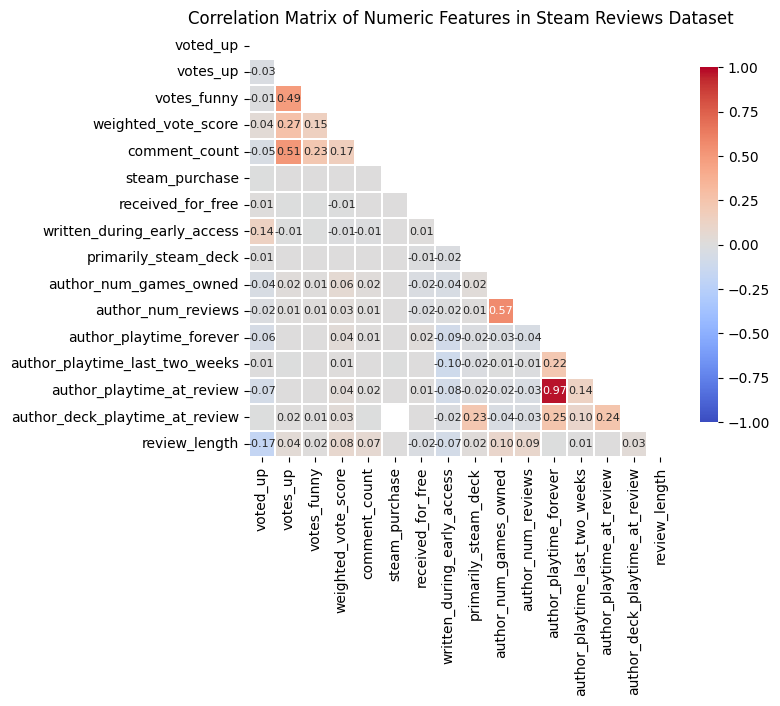

`author_playtime_forever` is highly positively correlated with `author_playtime_at_review` (0.97).


In [12]:
# Create correlation matrix for numeric columns only
corr_matrix = df.select_dtypes(include=[np.number, bool]).corr()

# Plot the correlation matrix
plt.figure(figsize=(8,8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) 
cols = corr_matrix.columns
ax = sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    center=0,
    square=True,
    annot=True, 
    fmt='.2f',
    linewidths=0.1,
    cbar_kws={'shrink': 0.6},
    annot_kws={'size': 8},
    # Create custom annotations that hide zeros
)

# Manually update annotations to hide zeros
for text in ax.texts:
    if text.get_text() in ['0.00', '-0.00']:
        text.set_text('')
ax.set_xticks(np.arange(len(cols)) + 0.5) # Ensure every tick/label is shown 
ax.set_yticks(np.arange(len(cols)) + 0.5)
ax.set_xticklabels(cols, rotation=90)
ax.set_yticklabels(cols, rotation=0)
plt.tight_layout()
plt.title('Correlation Matrix of Numeric Features in Steam Reviews Dataset')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Get the absolute correlation matrix and set diagonal to 0 to ignore self-correlation
high_corr = corr_matrix.unstack().to_frame('correlation') # Unstack the correlation matrix
high_corr['sign'] = np.where(high_corr['correlation'] >= 0, 'positive', 'negative') # Add a new column indicating if the correlation is positive or negative
high_corr['correlation'] = high_corr['correlation'].abs().drop_duplicates()
high_corr = high_corr[high_corr['correlation'] < 1]
high_corr = high_corr.sort_values(by='correlation', ascending=False)
for (var1, var2), row in high_corr.head(1).iterrows():
    print(f"`{var1}` is highly {row['sign']}ly correlated with `{var2}` ({row['correlation']:.2f}).")

`author_playtime_forever` is highly positively correlated with `author_playtime_at_review` (0.97). This is expected, as the total playtime should be at least as much as the playtime at the time of review.

Here is a summary of the correlations between numeric features and the target variable `voted_up`:

1. Strong Positive Predictors ($r \ge 0.49$)
    - `comment_count` ($r = 0.51$): Strongest predictor; highly correlated with community discussion.

    - `votes_funny` ($r = 0.49$): Excellent proxy for overall positive engagement.

2. Moderate Positive Predictor ($r = 0.27$)

    - `weighted_vote_score` ($r = 0.27$): Moderately correlated with the raw number of upvotes.

3. Weak or Negligible Predictors ($r \le 0.04$)

    - `review_length` ($r = 0.04$): Length of the text is not a significant factor.

    - `author_num_games_owned` ($r = 0.02$): Author's library size is negligible.

    - `author_playtime_at_review` ($r = 0.00$): Zero linear correlation with upvotes received.

    - `author_playtime_forever` ($r = 0.00$): Total lifetime playtime is unrelated to upvotes.

We also verify that there are no duplicate rows in the dataset.

In [13]:
# Check duplicate rows
df_duplicates = df[df.duplicated()]
print(f"There are {df_duplicates.shape[0]:,} duplicate rows.")

There are 0 duplicate rows.




We also visualize the distribution of reviews over time.


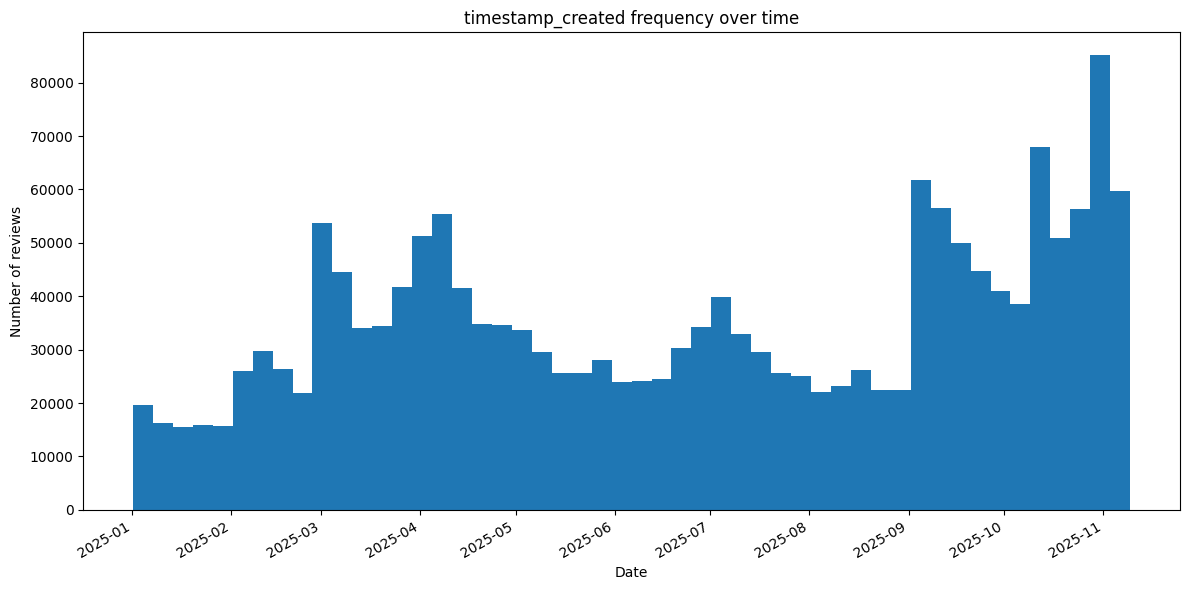

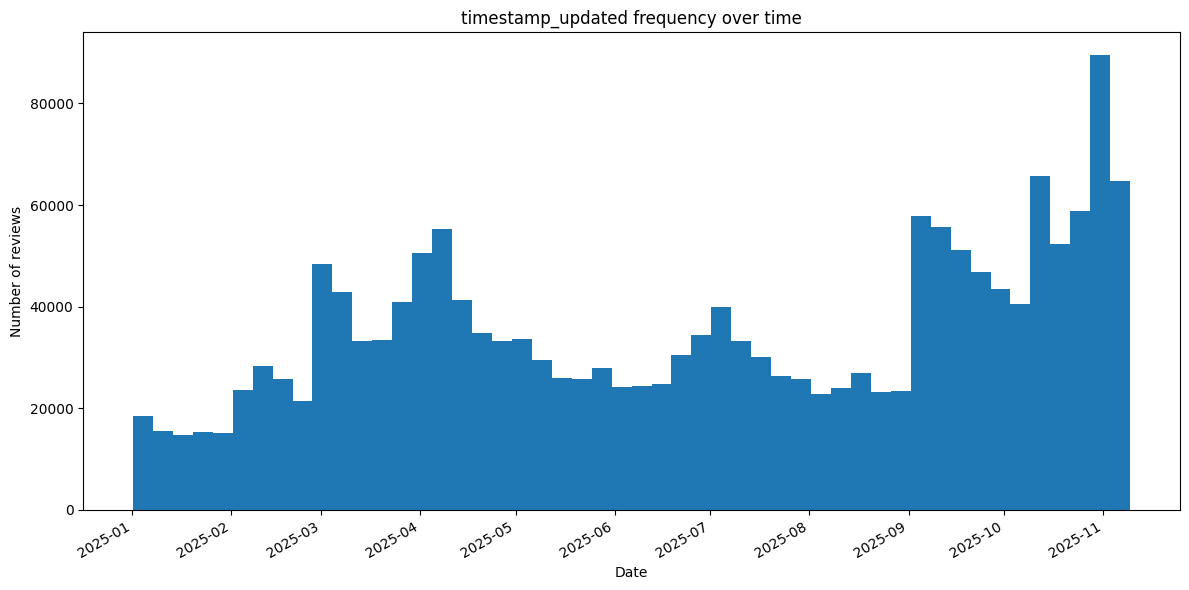

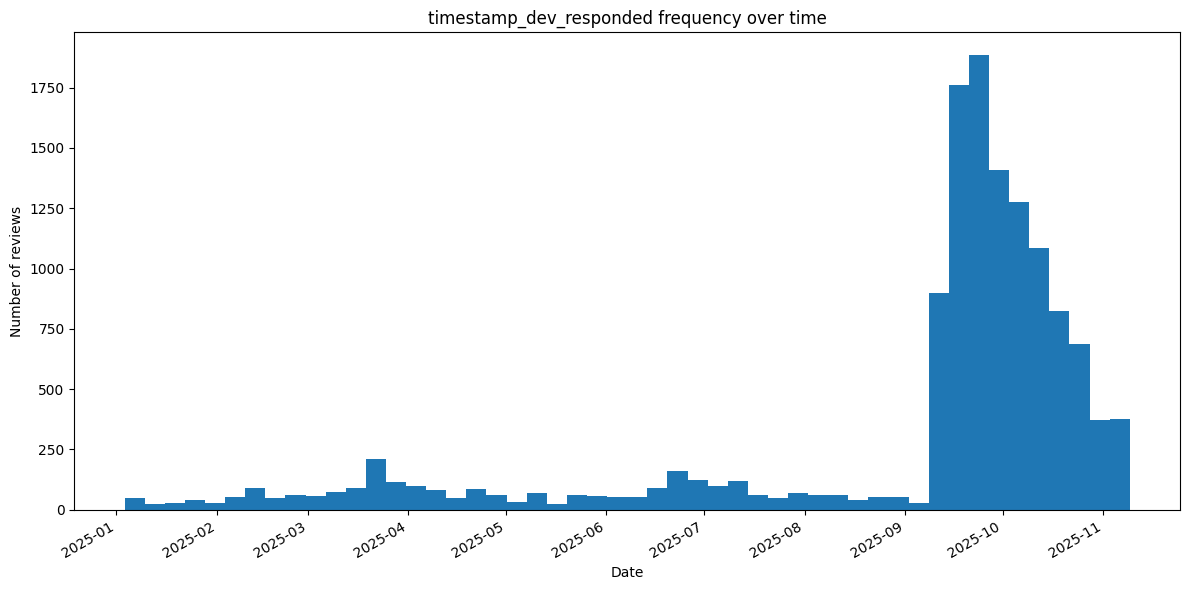

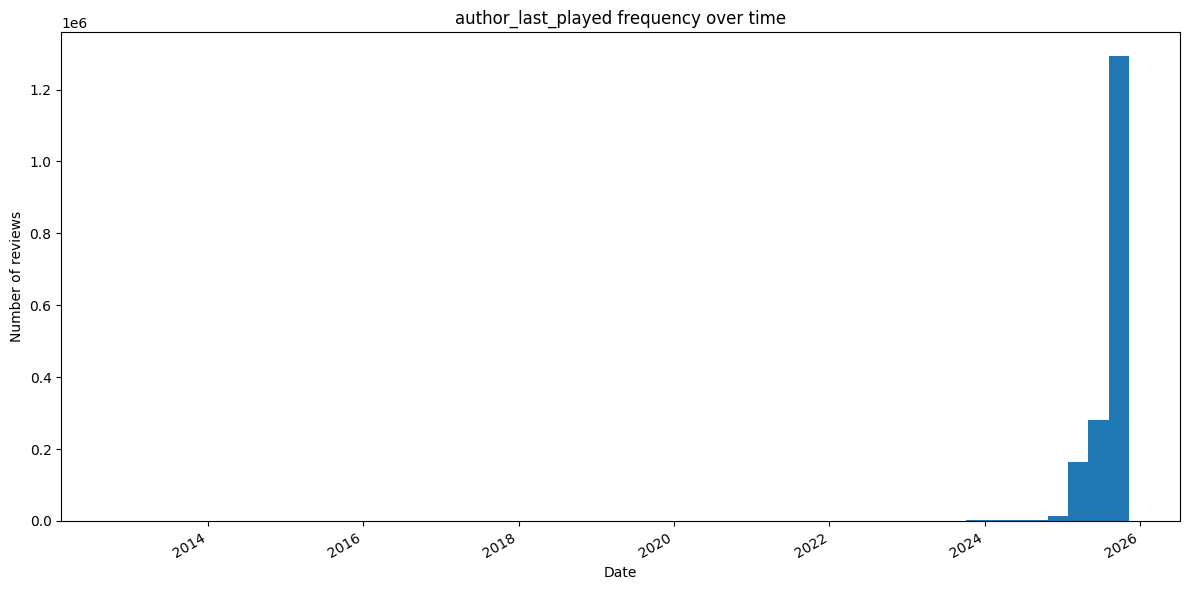

In [14]:
# Get datetime columns
timestamp_columns = ['timestamp_created', 'timestamp_updated', 'timestamp_dev_responded', 'author_last_played']
for col in timestamp_columns:
    # Histogram of review timestamps
    ts = df[col].dropna()
    plt.figure(figsize=(12,6))
    plt.hist(ts, bins=50)
    plt.xlabel('Date')
    plt.ylabel('Number of reviews')
    plt.title(f'{col} frequency over time')
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()





The number of upvotes, funny votes, and comments on reviews, as well as the playtime metrics, are all right-skewed, with most reviews having low values and a few reviews having very high values.


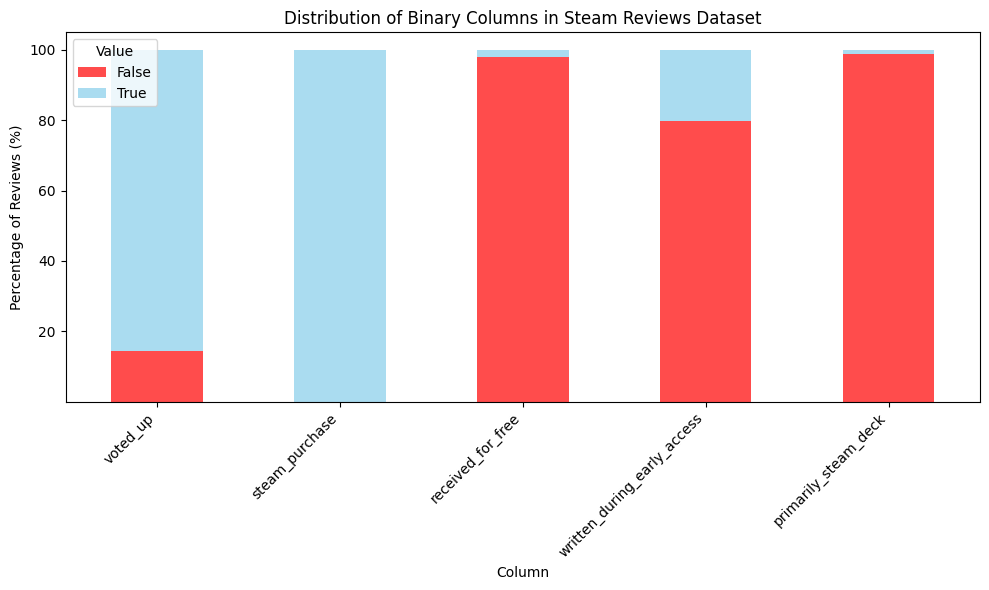

In [15]:
# Stacked bar chart for all binary columns
binary_columns = [col for col in df.columns if df[col].dropna().nunique() == 2]

# Compute percentages (of non-null values) for False/True for each binary column
false_counts = []
true_counts = []
for col in binary_columns:
    total = df[col].notnull().sum()
    if total == 0:
        false_counts.append(0.0)
        true_counts.append(0.0)
        continue
    false_counts.append(df[col].eq(False).sum() / total * 100)
    true_counts.append(df[col].eq(True).sum() / total * 100)

# Create DataFrame (remove unsupported kwargs from constructor)
counts_df = pd.DataFrame({'False': false_counts, 'True': true_counts}, index=binary_columns)

# Pass plotting color/alpha to the plot method instead
ax = counts_df.plot(kind='bar', stacked=True, figsize=(10,6), color=['red', 'skyblue'], alpha=0.7)
ax.set_xlabel('Column')
ax.set_ylabel('Percentage of Reviews (%)')
ax.set_title('Distribution of Binary Columns in Steam Reviews Dataset')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Value')
plt.tight_layout()
plt.show()

In [16]:
# See the numeric distribution of voted_up
df['voted_up'].value_counts()/df.shape[0]

voted_up
True     0.856659
False    0.143341
Name: count, dtype: float64

Many reviews had upvotes, almost all were purchased on Steam, most reviewers did not receive the game for free, about a fifth were written during early access of a game, and most reviewers did not play on a Steam Deck.

Importantly, we can see that `voted_up` is True in about 85% of all reviews. This means that our dependent is imbalanced which will need to be addressed when we build our model. We may need to focus on precision or recall in order to build a better model. 

### Target Variable: `voted_up`

In order to validate our results, we will look at a model that attempts to predict `voted_up` based on the other features of a review. This will help us understand if our results are justified.

#### `voted_up` Relationship with Categorical Variables

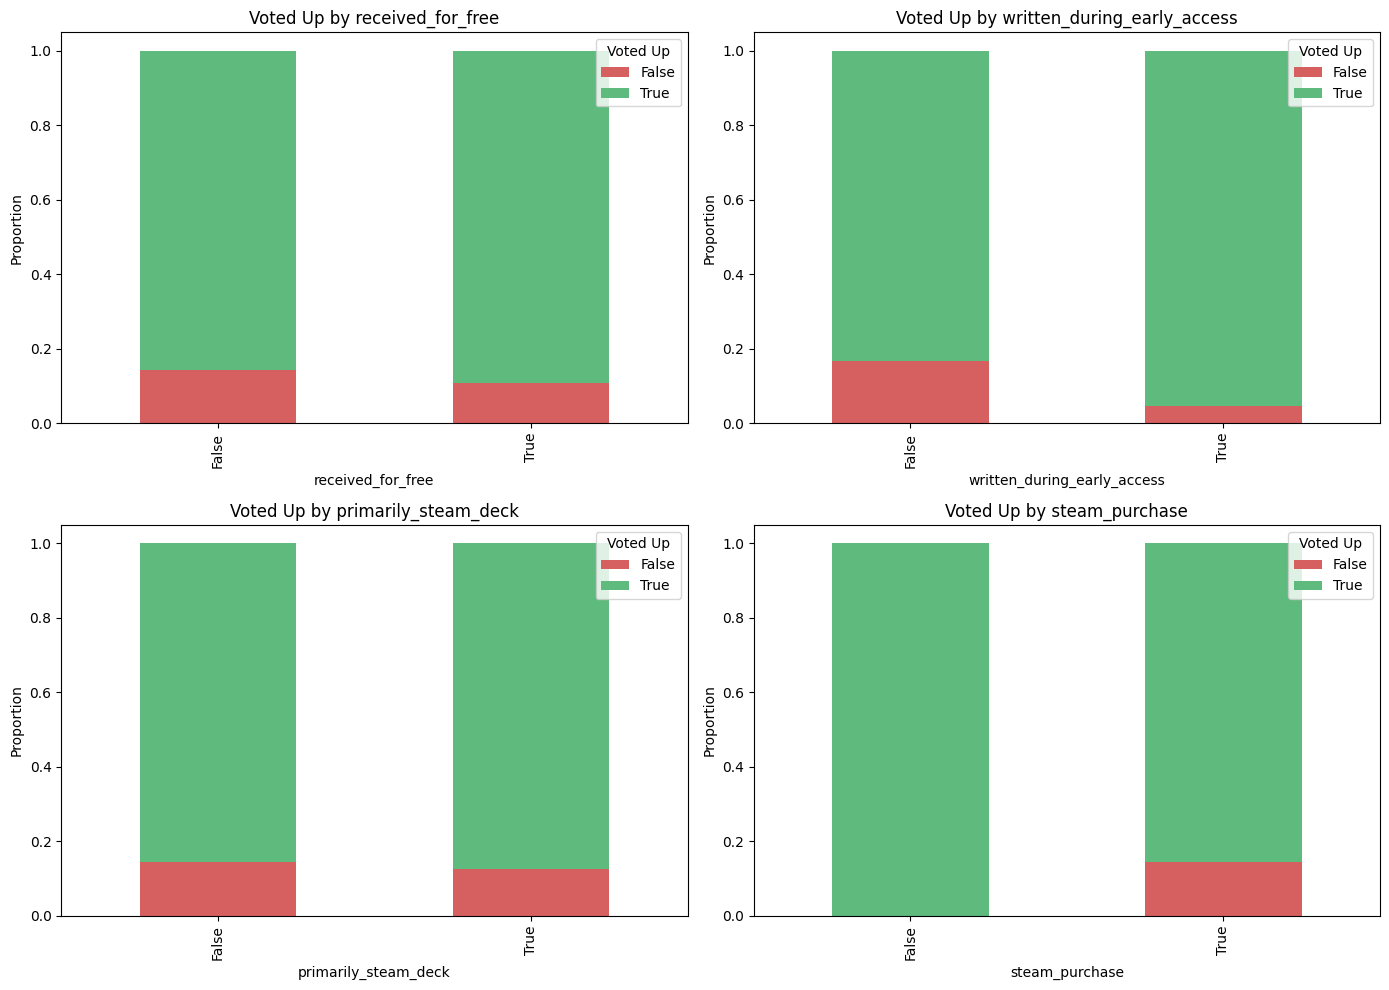

In [17]:
# Goal: See how boolean flags affect the vote ratio
bool_cols = ['received_for_free', 'written_during_early_access', 'primarily_steam_deck', 'steam_purchase']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(bool_cols):
    # Calculate percentages for normalized stacked bars
    ct = pd.crosstab(df[col], df['voted_up'], normalize='index')
    ct.plot(kind='bar', stacked=True, ax=axes[i], color=['#d65f5f', '#5fba7d'])
    axes[i].set_title(f'Voted Up by {col}')
    axes[i].set_ylabel('Proportion')
    axes[i].legend(title='Voted Up', loc='upper right')

plt.tight_layout()
plt.show()

In [18]:
for column in bool_cols:
    print(df[column].value_counts())

received_for_free
False    1739293
True       35669
Name: count, dtype: int64
written_during_early_access
False    1415108
True      359854
Name: count, dtype: int64
primarily_steam_deck
False    1756479
True       18483
Name: count, dtype: int64
steam_purchase
True     1774961
False          1
Name: count, dtype: int64


These graphs are a bit telling. We can see that:
1. Those who received the game for free were more likely to vote the game up. This group makes up a very small portion of the reviews, with only 35,669 reviews (approximately 2.0% of the total) coming from users who received the game for free.

2. Those who reviewed the game during early access were more likely to vote the game up. Reviews written during early access are a sizable minority, totaling 359,854 reviews (approximately 20.3% of the total).

3. Those who primarily use the steam deck are more likely to vote the game up. This is a small group, with only 18,483 reviews (approximately 1.0% of the total) coming from primary Steam Deck users.

4. Those who did not purchase the game on Steam seem to exclusively vote the game up. This observation is based on an extremely small sample size of only 1 review that was not purchased on Steam, compared to 1,774,961 reviews that were. The conclusion about this group is therefore statistically unreliable due to the count of one.

#### `voted_up` Relationship with Numeric Variables

/tmp/ipykernel_221493/3050487850.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='voted_up', y='author_playtime_at_review', data=df, palette='Set2')


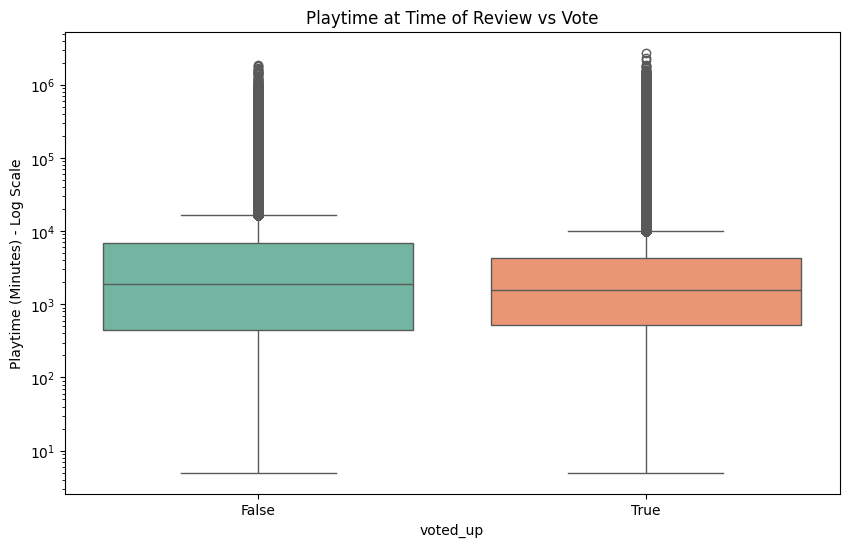

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='voted_up', y='author_playtime_at_review', data=df, palette='Set2')
plt.title('Playtime at Time of Review vs Vote')
plt.yscale('log') # Log scale handles the massive outliers typical in steam data
plt.ylabel('Playtime (Minutes) - Log Scale')
plt.show()

The median playtime is slightly higher for negative reviews, suggesting some users played the game extensively before deciding to vote it down, the overall distributions (especially the IQR) are very similar. This indicates that playtime alone is not a strong single predictor of a user's vote. The majority of positive and negative reviews come from users with comparable amounts of time played.

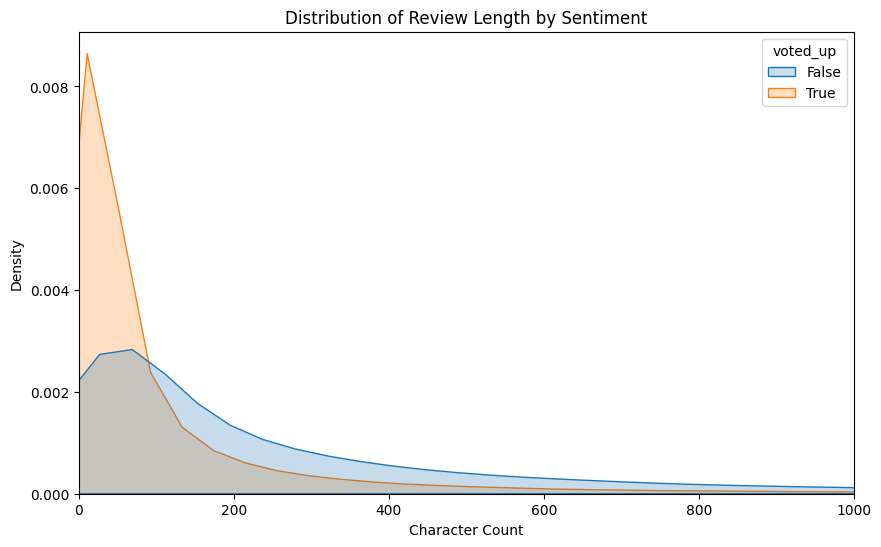

In [20]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='review_length', hue='voted_up', fill=True, common_norm=False)
plt.title('Distribution of Review Length by Sentiment')
plt.xlabel('Character Count')
plt.xlim(0, 1000) # Limiting x-axis to focus on the bulk of reviews
plt.show()

From this distribution of review length we can see that positive reviews are short, while negative reviews are generally more verbose. This confirms that the most common behavior for a happy user is a quick endorsement, whereas a critical user is more motivated to provide a detailed explanation. This difference in motivation leads to a sharp spike in density for positive reviews near zero length, while negative reviews have a flatter, longer distribution.

## Additional Data Preprocessing for Modeling

### Handling Null Data

From before, we observed that there are missing observations related to developer responses to reviews, which is expected as not all reviews receive responses. There also appear to be some people who never played the game but still left a review, resulting in a missing `author_playtime_at_review` value. Additionally, many people did not play on a Steam Deck, leading to missing `author_played_on_steam_deck` values.

In [21]:
# Dropping columns with nulls
df = df.drop(columns = null_counts[null_counts > 0].index.tolist(), errors='ignore')

df.head()

,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,...,received_for_free,written_during_early_access,primarily_steam_deck,game_appid,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,review_length
0,208702347,english,Hunt animal. Be happy. Repeat process. Profit.,2025-11-08 10:06:33,2025-11-08 10:06:33,True,0,0,0.50000,0,...,False,False,False,518790,76561199223799852,0,14,2404,669,46
1,208691821,english,Gotcha Bitch.,2025-11-08 06:30:19,2025-11-08 06:30:19,True,1,0,0.52381,0,...,False,False,False,518790,76561198445449939,0,24,892,0,13
2,208690429,english,very fun and realistic\r\n,2025-11-08 05:59:10,2025-11-08 05:59:10,True,0,0,0.50000,0,...,False,False,False,518790,76561199723908114,0,6,1503,1190,24
3,208671048,english,I hate this game...\nMy friends only play this...,2025-11-07 23:31:38,2025-11-07 23:34:27,True,0,0,0.47619,0,...,False,False,False,518790,76561199767564132,0,16,217,217,104
4,208670962,english,its very fun and relaxing\r\n,2025-11-07 23:29:58,2025-11-07 23:29:58,True,0,0,0.50000,0,...,False,False,False,518790,76561198038821609,0,2,1845,867,27


### Handle Categorical Variables

Instead of inlcuding a string `review` variable, we generate a sentiment score based on the review text using NLTK's VADER sentiment analysis tool. This score will help quantify the emotional tone of each review, providing an additional feature that may correlate with whether a review is positive or negative.

In [22]:
# Create sentiment score based on review text
sia = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['review'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])

Then, we filter out any other categorical variables that are not useful for modeling--namely, ID variables and review text fields. 

In [23]:
columns_to_drop = ['recommendationid', 'author_steamid', 'game_appid', 'review']
df_dropped = df.copy()
df_dropped.drop(columns=columns_to_drop, inplace=True)

We also convert the categorical variable `language` into several dummy variables using one-hot encoding to make it suitable for modeling.

In [24]:
# One-hot encode language variable
df_dummies = df_dropped.copy()
df_dummies = pd.get_dummies(df_dummies, columns=['language'], drop_first=True)
df_dummies.head()

,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,...,review_length,sentiment_score,language_german,language_koreana,language_latam,language_norwegian,language_russian,language_tchinese,language_turkish,language_ukrainian
0,2025-11-08 10:06:33,2025-11-08 10:06:33,True,0,0,0.50000,0,True,False,False,...,46,0.7650,False,False,False,False,False,False,False,False
1,2025-11-08 06:30:19,2025-11-08 06:30:19,True,1,0,0.52381,0,True,False,False,...,13,-0.5859,False,False,False,False,False,False,False,False
2,2025-11-08 05:59:10,2025-11-08 05:59:10,True,0,0,0.50000,0,True,False,False,...,24,0.5563,False,False,False,False,False,False,False,False
3,2025-11-07 23:31:38,2025-11-07 23:34:27,True,0,0,0.47619,0,True,False,False,...,104,-0.2110,False,False,False,False,False,False,False,False
4,2025-11-07 23:29:58,2025-11-07 23:29:58,True,0,0,0.50000,0,True,False,False,...,27,0.7939,False,False,False,False,False,False,False,False


### Standardize Features

We standardize the features to have mean 0 and standard deviation 1. Although the tree-based models from the previous assignment do not require standardization, this is important for SVMs since they are sensitive to the scale of the input features. We are using `RobustScaler()` to reduce the influence of outliers.

In [25]:
# Identify numerical columns
num_cols = df_dummies.select_dtypes(include=[np.number]).columns
df_standardized = df_dummies.copy()
scaler = RobustScaler()

# Fit and transform the numerical columns
df_standardized[num_cols] = scaler.fit_transform(df_standardized[num_cols])

df_standardized.head()

,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,...,review_length,sentiment_score,language_german,language_koreana,language_latam,language_norwegian,language_russian,language_tchinese,language_turkish,language_ukrainian
0,2025-11-08 10:06:33,2025-11-08 10:06:33,True,0.0,0.0,0.00000,0.0,True,False,False,...,0.040323,0.484076,False,False,False,False,False,False,False,False
1,2025-11-08 06:30:19,2025-11-08 06:30:19,True,1.0,0.0,0.02381,0.0,True,False,False,...,-0.225806,-1.419673,False,False,False,False,False,False,False,False
2,2025-11-08 05:59:10,2025-11-08 05:59:10,True,0.0,0.0,0.00000,0.0,True,False,False,...,-0.137097,0.189966,False,False,False,False,False,False,False,False
3,2025-11-07 23:31:38,2025-11-07 23:34:27,True,0.0,0.0,-0.02381,0.0,True,False,False,...,0.508065,-0.891347,False,False,False,False,False,False,False,False
4,2025-11-07 23:29:58,2025-11-07 23:29:58,True,0.0,0.0,0.00000,0.0,True,False,False,...,-0.112903,0.524803,False,False,False,False,False,False,False,False


### Split and balance data

Lastly, we split the data into training and test sets and balance the training data.

In [26]:
# Separate features and target
X = df_standardized.drop(columns=['voted_up'])
y = df_standardized['voted_up']

# Randomly split the X and y arrays into 30 percent test data and 70 percent training data.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)

In [27]:
# Balance training data
print(f"Unbalanced training set size: {X_train.shape[0]:,}")
print(f"Unbalanced training set class distribution: {Counter(y_train)}")
undersampler = RandomUnderSampler(random_state=1)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)
print(f"Resampled training set size: {X_train_resampled.shape[0]:,}")
print(f"Resampled training set class distribution: {Counter(y_train_resampled)}")

Unbalanced training set size: 1,242,473
Unbalanced training set class distribution: Counter({True: 1064376, False: 178097})
Resampled training set size: 356,194
Resampled training set class distribution: Counter({False: 178097, True: 178097})


### Filtering the Features

We filter out features that are not useful for modeling, such as ID variables and review text fields. We also convert categorical variables into dummy variables using one-hot encoding to make them suitable for modeling.

In [28]:
# Removing date fields
X_train_resampled = X_train_resampled.select_dtypes(exclude=['datetime64[ns]'])
X_test = X_test.select_dtypes(exclude=['datetime64[ns]'])

# Removing text fields
X_train_resampled = X_train_resampled.select_dtypes(exclude=['object'])
X_test = X_test.select_dtypes(exclude=['object'])

X_train_resampled.dtypes

votes_up                          float64
votes_funny                       float64
weighted_vote_score               float64
comment_count                     float64
steam_purchase                       bool
received_for_free                    bool
written_during_early_access          bool
primarily_steam_deck                 bool
author_num_games_owned            float64
author_num_reviews                float64
author_playtime_forever           float64
author_playtime_last_two_weeks    float64
review_length                     float64
sentiment_score                   float64
language_german                      bool
language_koreana                     bool
language_latam                       bool
language_norwegian                   bool
language_russian                     bool
language_tchinese                    bool
language_turkish                     bool
language_ukrainian                   bool
dtype: object

Our data is ready for us train our models.

# Create Models

First, we anticipate the need to compare our models so we'll compile all of our models' results into one list.

In [29]:
all_model_results = {}

## Support Vector Machine (SVM)

We'll first create a linear SVM using stochastic gradient descent and perform a randomized search to tune 
hyperparameters, retaining the best model.

In [30]:
# Create a function to train an SVM model
def train_svm_model(X_train, y_train, X_test, y_test):
    pipeline = make_pipeline(
        StandardScaler(),
        SGDClassifier(
            loss='hinge'
            , random_state=1
        )
    )
    
    param_dist = [{'sgdclassifier__alpha': loguniform(0.0001, 10.0)}]
    
    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_dist,
        n_iter=20,
        scoring='accuracy',
        cv=10,
        n_jobs=-1,
        random_state=1
    )

    print("Training SVM...")

    search.fit(X_train, y_train)
    
    best_model = search.best_estimator_
    y_train_pred = best_model.predict(X_train)
    y_pred = best_model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)

    test_acc = accuracy_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)

    print(f"Training Accuracy: {train_acc*100:.2f}%")
    print(f"Training Recall: {train_recall*100:.2f}%")
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Recall: {test_recall*100:.2f}%")
    
    return (best_model, train_acc, train_recall,test_acc, test_recall)

In [31]:
# Run the function
svm_model, svm_train_acc, svm_train_recall, svm_test_acc, svm_test_recall = train_svm_model(
    X_train_resampled, y_train_resampled, X_test, y_test
)

all_model_results['SVM'] = {
    'model': svm_model,
    'train_accuracy': svm_train_acc,
    'test_accuracy': svm_test_acc,
    'test_recall': svm_test_recall
}

Training SVM...
Training Accuracy: 76.72%
Training Recall: 81.59%
Test Accuracy: 80.18%
Test Recall: 81.63%


The SVM model has a test accuracy of 80% which is slightly worse than randomly guessing the majority class (85%). The test group's recall is 81% which is pretty good and performs about the same as training recall, indicating that the model is not overfitting.

## SVM with RBF Kernel
We will also explore using the RBF kernel. To reduce training time, we optimize performance by performing hyperparameter tuning on a smaller, stratified subset of the data and employing feature selection to reduce dimensionality, before refitting the best estimator on the full training set.

In [ ]:
def train_rbf_model(X_train, y_train, X_test, y_test, tune_sample_frac=0.2):
    # Create a tuning subsample
    X_tune, y_tune = resample(
        X_train, y_train, 
        n_samples=int(len(X_train) * tune_sample_frac),
        random_state=1,
        stratify=y_train
    )

    pipeline = make_pipeline(
        # FIX: Set n_jobs=1 here to avoid nested parallelism conflicts with RandomizedSearchCV
        SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=1)),
        StandardScaler(),
        SVC(kernel='rbf', random_state=1)
    )
    
    param_dist = [
        {
            'selectfrommodel__threshold': ['mean', 'median'],
            'svc__C': loguniform(0.1, 1000.0),
            'svc__gamma': loguniform(0.0001, 1.0)
        }
    ]
    
    # Perform the search (n_jobs=-1 here handles the parallelization)
    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_dist,
        n_iter=5,
        scoring='recall',
        cv=3,
        n_jobs=-1,
        random_state=1
    )
    
    search.fit(X_tune, y_tune)
    
    print(f"Best Params found: {search.best_params_}")
    
    # Retrain the best model configuration on the full training set
    best_model = search.best_estimator_
    best_model.fit(X_train, y_train)
    
    y_train_pred = best_model.predict(X_train)
    y_pred = best_model.predict(X_test)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)

    test_acc = accuracy_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)

    print(f"Training Accuracy: {train_acc*100:.2f}%")
    print(f"Training Recall: {train_recall*100:.2f}%")
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Recall: {test_recall*100:.2f}%")

    return (best_model, train_acc, train_recall, test_acc, test_recall)

In [ ]:
# Run the function
svm_rbf_model, svm_rbf_train_acc, svm_rbf_train_recall, svm_rbf_test_acc, svm_rbf_test_recall = train_rbf_model(
    X_train_resampled, y_train_resampled, X_test, y_test
)

all_model_results['SVM RBF'] = {
    'model': svm_rbf_model,
    'train_accuracy': svm_rbf_train_acc,
    'test_accuracy': svm_rbf_test_acc,
    'test_recall': svm_rbf_test_recall
}

/home/richie/work/cuny-msds/data622-machine-learning-and-big-data/assignments/DATA622/data622-python-venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Params found: {'selectfrommodel__threshold': 'median', 'svc__C': np.float64(73.09405637964043), 'svc__gamma': np.float64(0.1625661107512622)}


This model took a long time to find the best hyperparameters and to run the predictions. This is because SVMs with RBF kernels are computationally intensive, especially on large datasets with many features. The hyperparameter tuning process involves training multiple models with different parameter combinations, which further increases the computational load. Additionally, the RBF kernel requires calculating distances between all pairs of data points, leading to increased processing time as the dataset size grows.

# REVISIT: HEY GUYS DISCUSS RESULTS HERE. IF WE CAN'T GET THAT SVM RBF KERNEL TO WORK THEN WE'LL JUST OMIT IT AND ONLY DISCUSS THE LINEAR SVM RESULTS. IF WE CAN GET IT TO WORK THEN WE'LL NEED TO REVISIT OUR MODEL RESULTS AND CONCLUSIONS ACCORDINGLY.

## Decision Trees

We will create a decision tree classifier and perform a grid search to tune hyperparameters, retaining the best model.

In [32]:
def train_best_decision_tree(X_train, y_train, X_test, y_test):
    """
    Trains a Decision Tree model using GridSearchCV to find the best hyperparameters.
    """
    
    dt = DecisionTreeClassifier(random_state=1)
    
    param_grid = [
        {
            'criterion': ['gini', 'entropy'],
            'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, None]
        }
    ]
    
    # Using k-fold cross-validation (cv=10) to find the best model.
    grid_search = GridSearchCV(
        estimator=dt,
        param_grid=param_grid,
        scoring='accuracy',
        cv=10,
        n_jobs=-1
    )
    
    print("Tuning Decision Tree...")
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    print(f"Best Params: {grid_search.best_params_}")
    
    y_train_pred = best_model.predict(X_train)
    y_pred = best_model.predict(X_test)
    
    print("\nClassification Report on Test Set:")
    print(classification_report(y_test, y_pred))
    
    train_acc = accuracy_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    
    print(f"Training Accuracy: {train_acc*100:.2f}%")
    print(f"Training Recall: {train_recall*100:.2f}%")
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Recall: {test_recall*100:.2f}%")
    
    return (best_model, train_acc, train_recall, test_acc, test_recall)

In [35]:
# Run the function
decision_tree_model, decision_tree_train_acc, decision_tree_train_recall, decision_tree_test_acc, decision_tree_test_recall = train_best_decision_tree(
    X_train_resampled, y_train_resampled, X_test, y_test
)

all_model_results['Decision Tree'] = {
    'model': decision_tree_model,
    'train_accuracy': decision_tree_train_acc,
    'test_accuracy': decision_tree_test_acc,
    'test_recall': decision_tree_test_recall
}

Tuning Decision Tree...
Best Params: {'criterion': 'entropy', 'max_depth': 12}

Classification Report on Test Set:
              precision    recall  f1-score   support

       False       0.46      0.82      0.59     76327
        True       0.97      0.84      0.90    456162

    accuracy                           0.84    532489
   macro avg       0.71      0.83      0.74    532489
weighted avg       0.89      0.84      0.85    532489

Training Accuracy: 84.09%
Training Recall: 85.16%
Test Accuracy: 83.78%
Test Recall: 84.10%


The best decision tree was found to be an 'entropy'-based tree with a max depth of 12. THis model has fairly similar recall and accuracy scores across the training and test sets, providing evidence that it is not overfitting. 

Amongst the reviews where the outcome was positive, the model acheived a precision of 97%. Although for the minority class the model had a recall of 82% but a precision of only 46% meaning that while it was able to identify most of the positive reviews, it also misclassified a significant number of negative reviews as positive. This model is biased towards minimizing false positives in the true class.

## Random Forest

We will create a random forest classifier and perform a grid search to tune hyperparameters, retaining the best model.

In [59]:
def train_random_forest_model(X_train, y_train, X_test, y_test):
    """
    Trains a Random Forest model using RandomizedSearchCV to find efficient hyperparameters
    while keeping training time manageable.
    """
    
    rf = RandomForestClassifier(random_state=1)
    
    param_grid = {
        'n_estimators': [25, 50, 100], 
        'max_depth': [None, 10, 20],
        'criterion': ['gini', 'entropy']
    }
    
    search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_grid,
        n_iter=10,
        scoring='accuracy',
        cv=5,
        n_jobs=-1,
        random_state=1
    )
    
    # 4. Fit the model
    print("Tuning Random Forest...")
    search.fit(X_train, y_train)
    
    best_model = search.best_estimator_
    print(f"Best Params: {search.best_params_}")
    
    # 5. Evaluation
    y_train_pred = best_model.predict(X_train)
    y_pred = best_model.predict(X_test)
    
    print("\nClassification Report on Test Set:")
    print(classification_report(y_test, y_pred))
    
    train_acc = accuracy_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    
    test_acc = accuracy_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    
    print(f"Training Accuracy: {train_acc*100:.2f}%")
    print(f"Training Recall: {train_recall*100:.2f}%")
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Recall: {test_recall*100:.2f}%")
    
    return (best_model, train_acc, train_recall, test_acc, test_recall)

In [37]:
# Run the function
rf_model, rf_train_acc, rf_train_rec, rf_test_acc, rf_test_rec = train_random_forest_model(
    X_train_resampled, y_train_resampled, X_test, y_test
)

all_model_results['Random Forest'] = {
    'model': rf_model,
    'train_accuracy': rf_train_acc,
    'test_accuracy': rf_test_acc,  
    'test_recall': rf_test_rec
}

Tuning Random Forest...
Best Params: {'n_estimators': 50, 'max_depth': 20, 'criterion': 'gini'}

Classification Report on Test Set:
              precision    recall  f1-score   support

       False       0.47      0.83      0.60     76327
        True       0.97      0.84      0.90    456162

    accuracy                           0.84    532489
   macro avg       0.72      0.84      0.75    532489
weighted avg       0.90      0.84      0.86    532489

Training Accuracy: 89.43%
Training Recall: 90.95%
Test Accuracy: 84.13%
Test Recall: 84.26%


Our Random forest model uses 50 estimators and a maximum depth of 20. This model seems to perform very similarly to our previous decision tree model. Because of the added complexity of the random forest, we might have expected a slight improvement in performance, but it appears that the random forest is not significantly outperforming the single decision tree in this case.

## AdaBoost

We will create an AdaBoost classifier and perform a grid search to tune hyperparameters, retaining the best model.

In [38]:
def train_adaboost_model(X_train, y_train, X_test, y_test):
    """
    Trains an AdaBoost model using RandomizedSearchCV to find efficient hyperparameters.
    """
    
    # 1. Define the model
    # We set random_state for reproducibility.
    ada = AdaBoostClassifier(random_state=1)
    
    # 2. Define the parameter distribution
    # Chapter 7 highlights n_estimators and learning_rate as key parameters.
    # We use loguniform for learning_rate to explore different magnitudes efficiently.
    param_grid = {
        'n_estimators': [50, 100, 200], 
        'learning_rate': loguniform(0.01, 1.0)
    }
    
    # 3. Randomized Search
    # Using RandomizedSearchCV for efficiency as per Chapter 6.
    search = RandomizedSearchCV(
        estimator=ada,
        param_distributions=param_grid,
        n_iter=10,  # Limit iterations for speed
        scoring='accuracy',
        cv=5,
        n_jobs=-1,
        random_state=1
    )
    
    # 4. Fit the model
    print("Tuning AdaBoost...")
    search.fit(X_train, y_train)
    
    best_model = search.best_estimator_
    print(f"Best Params: {search.best_params_}")
    
    # 5. Evaluation
    y_train_pred = best_model.predict(X_train)
    y_pred = best_model.predict(X_test)
    
    print("\nClassification Report on Test Set:")
    print(classification_report(y_test, y_pred))
    
    train_acc = accuracy_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    
    test_acc = accuracy_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    
    print(f"Training Accuracy: {train_acc*100:.2f}%")
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Recall: {test_recall*100:.2f}%")
    
    return (best_model, train_acc, train_recall, test_acc, test_recall)

In [39]:
# Run the function
ada_model, ada_train_acc, ada_train_rec, ada_test_acc, ada_test_rec = train_adaboost_model(
    X_train_resampled, y_train_resampled, X_test, y_test
)
all_model_results['AdaBoost'] = {
    'model': ada_model,
    'train_accuracy': ada_train_acc,
    'test_accuracy': ada_test_acc,  
    'test_recall': ada_test_rec
}

Tuning AdaBoost...
Best Params: {'learning_rate': np.float64(0.5704727088203682), 'n_estimators': 100}

Classification Report on Test Set:
              precision    recall  f1-score   support

       False       0.46      0.79      0.58     76327
        True       0.96      0.85      0.90    456162

    accuracy                           0.84    532489
   macro avg       0.71      0.82      0.74    532489
weighted avg       0.89      0.84      0.85    532489

Training Accuracy: 81.95%
Test Accuracy: 83.83%
Test Recall: 84.62%


The AdaBoost model uses 100 estimators and a learning rate of 0.57.

With an accuracy of 84.6% on the test set, the AdaBoost model performs similarly to the previous decision tree and random forest models.

# Model Comparison

Below we convert the dataframe into a dataframe for easier comparison and analyze the results.

In [ ]:
# Get all classification reports
for model_name in all_model_results.keys():
    model = all_model_results[model_name]['model']
    y_pred = model.predict(X_test)
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))


Classification Report for SVM:

              precision    recall  f1-score   support

       False       0.39      0.71      0.51     76327
        True       0.94      0.82      0.88    456162

    accuracy                           0.80    532489
   macro avg       0.67      0.77      0.69    532489
weighted avg       0.87      0.80      0.82    532489


Classification Report for Decision Tree:

              precision    recall  f1-score   support

       False       0.46      0.82      0.59     76327
        True       0.97      0.84      0.90    456162

    accuracy                           0.84    532489
   macro avg       0.71      0.83      0.74    532489
weighted avg       0.89      0.84      0.85    532489


Classification Report for Random Forest:

              precision    recall  f1-score   support

       False       0.47      0.83      0.60     76327
        True       0.97      0.84      0.90    456162

    accuracy                           0.84    532489
   macro 

Comoparing the model results, we can see that the random forest is slightly better than the other models. With a False class recall of 83% and a false class precision score of 47%, this model is the best at identifying positive reviews while minimizing false positives.

Although this is the best model, it's still not very good at predicting the minority class and there is likely room for improvement.

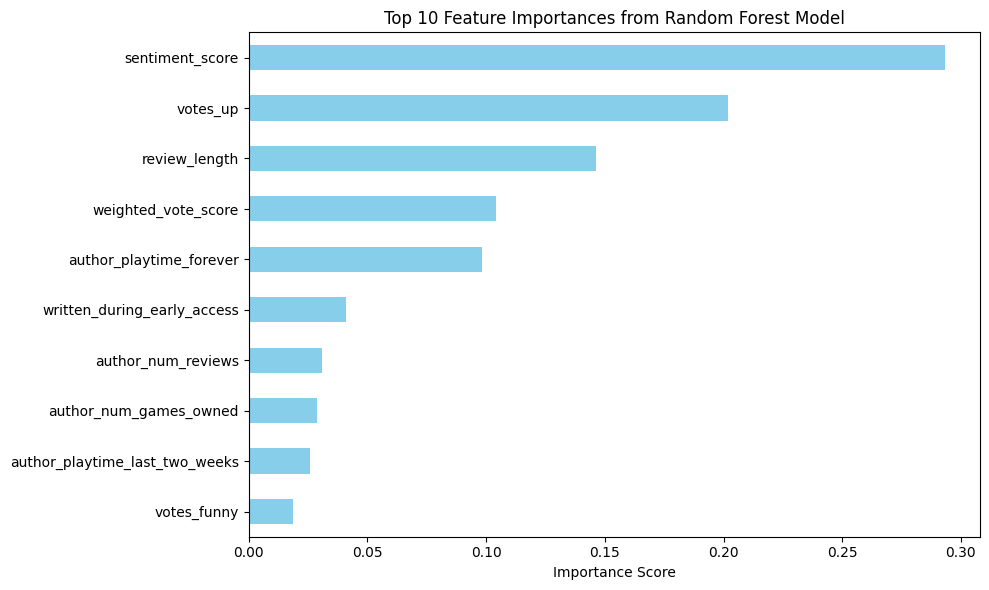

In [60]:
# Get the variable importance from the Random Forest model
rf_model = all_model_results['Random Forest']['model']
importances = rf_model.feature_importances_
feature_names = X_train_resampled.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot the top 10 important features
plt.figure(figsize=(10, 6))
feature_importances.head(10).plot(kind='barh', color='skyblue')
plt.xlabel('Importance Score')
plt.title('Top 10 Feature Importances from Random Forest Model')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

From the above graph we can see the importance of each feature in the random forest model. The most important feature is the `sentiment_score` which is understandable since it directly captures the emotional tone of the review text. Following that, `votes_up` and `review_length` are the second and third most imporant and this makes sense since it reflects the community's positive engagement with the review and that longer reviews seemed to be more negative in general.

# Conclusion and Next Steps

In our analysis we found that although our models were able to predict positive reviews with reasonable accuracy, they struggled with identifying negative reviews due to the imbalanced nature of the dataset. The random forest model performed the best among the models tested, but there is still significant room for improvement, particularly in recall and precision for the minority class.

The most important feature is the `sentiment_score`, indicating that the emotional tone of the review text plays a crucial role in determining whether a review is positive or negative. Other significant features include `votes_up` and `review_length`, which reflect community engagement and the depth of feedback provided by users.

In the future, we suspect that we can improve the model performance by further devleloping methods to extract specific features directly from the review text, moving us a bit further from the metadata and a sentiment score. We suspect this can be best acheived by using NLP techniquest o categorize each review beased on wheither it touches on dsiticnt elements of the gaming experience, such as negative aspects like "broken", "crash", or positive aspects like "fun", "engaging", etc.

With this we can help understand why users leave positive or negative reviews which can help developers improve their games and marketing strategies.